## Setup, Loading Data and CDFs

In [18]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'blue'

In [19]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)
FULL_DATA_NAME

Name the notebook:
blue_wavelet_full_agriVision.ipynb


'agriVision-full-wavelet-blue'

In [20]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = True
CWD

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\agriVision\\full\\wavelet\\blue'

In [21]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [22]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:2]: # TODO
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 9000,
 3: 36000,
 4: 144000,
 5: 576000,
 6: 2304000,
 7: 9216000,
 8: 36864000,
 9: 147456000,
 10: 589824000}

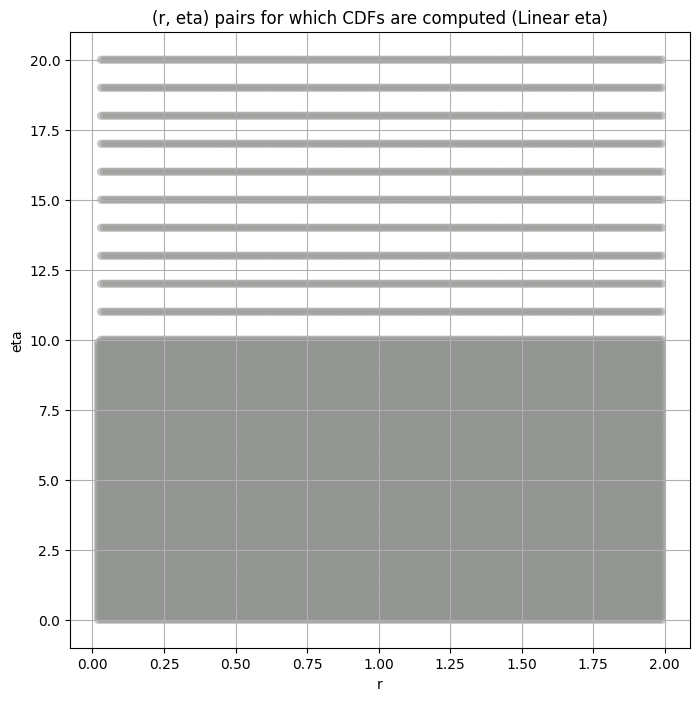

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, 0), <scipy.interpolate._fitpack2.Inter...",0.02,0.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,4.553186e+99,NaN
1,"((0.02, 0.1), <scipy.interpolate._fitpack2.Int...",0.02,0.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.560477e+100,NaN
2,"((0.02, 0.2), <scipy.interpolate._fitpack2.Int...",0.02,0.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,6.013272e+101,NaN
3,"((0.02, 0.3), <scipy.interpolate._fitpack2.Int...",0.02,0.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.824903e+102,NaN
4,"((0.02, 0.4), <scipy.interpolate._fitpack2.Int...",0.02,0.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.104347e+103,NaN


In [23]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [24]:
n_bootstrap = int(1e5) # TODO
bootstrap_size = int(1e4)
ci = 0.99

In [25]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if False or not master_df_var_kurt_path.exists(): # TODO
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,188570.730000,99638.340000,330262.220000,536.03296,113.304540,760.94360,9000.0
3,42568.312000,23773.760000,71607.330000,488.99530,135.974520,891.27313,36000.0
4,10773.336000,5322.670000,20877.791000,785.24280,131.392270,1768.95340,144000.0
5,1800.434900,923.853000,3624.655000,858.03740,109.913740,2074.88330,576000.0
6,390.887500,183.288650,971.469850,1521.53970,104.035530,3444.52950,2304000.0
7,98.479220,41.024357,351.604030,3306.70500,84.348870,5672.12000,9216000.0
8,33.173733,15.926921,100.374084,2264.61400,78.321760,4638.63770,36864000.0
9,11.252635,4.427865,43.877705,5137.09860,82.329865,6105.37160,147456000.0
10,1.875914,0.615992,10.184826,9775.98100,78.684250,7496.85840,589824000.0


## Initial Grid Search and Hypothesis Test Plots

In [26]:
EXCLUDE_CUTOFFS = [0, 100, 400] #[0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400]
SCALE_CAP = 1e5

In [ ]:
augmented_obs_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_obs_var_df.csv"))
augmented_obs_var_df = var_kurt_df[['obs_var']].copy()
augmented_obs_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    madd_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))
        madd_arr.append(np.mean(np.abs(group_data_map[group] - np.mean(group_data_map[group]))))

    augmented_obs_var_df[f"var_exclude_{val}"] = temp_arr
    augmented_obs_var_df[f"MAD"] = madd_arr

augmented_obs_var_df.to_csv(augmented_obs_var_df_path)
augmented_obs_var_df

,obs_var,var_exclude_0,MAD,var_exclude_100,var_exclude_400
layer,,,,,
2,188570.730000,188570.734375,158.803253,36420.285156,16658.740234
3,42568.312000,42568.312500,70.613350,12236.730469,7121.162598
4,10773.336000,10773.335938,31.406000,3574.999512,2194.888672
5,1800.434900,1800.434937,13.657659,642.706543,398.910187
6,390.887500,390.887512,6.584007,129.362122,82.370354
7,98.479220,98.479218,3.446948,29.994589,21.009548
8,33.173733,33.173733,2.206926,11.896943,8.784658
9,11.252635,11.252635,1.132474,3.280626,2.395398
10,1.875914,1.875914,0.412296,0.463169,0.331123


####
Layer  2


100%|██████████| 21967/21967 [01:26<00:00, 255.02it/s]


Finding Minimum after computing 21967 CDFs
2 0 0.024065082317002773 188570.73


100%|██████████| 21967/21967 [00:50<00:00, 437.42it/s]


Finding Minimum after computing 21967 CDFs
2 100 0.019771232335846545 36420.285


100%|██████████| 21967/21967 [01:11<00:00, 308.84it/s]


Finding Minimum after computing 21967 CDFs
2 400 0.053042817111951246 16658.74
Number of samples: 9000, Without approximation : 9000.0


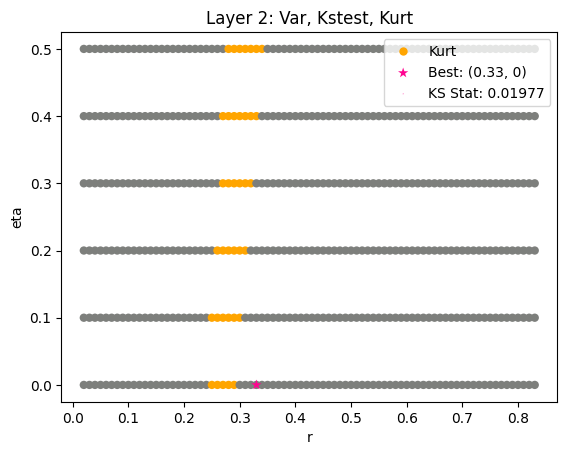

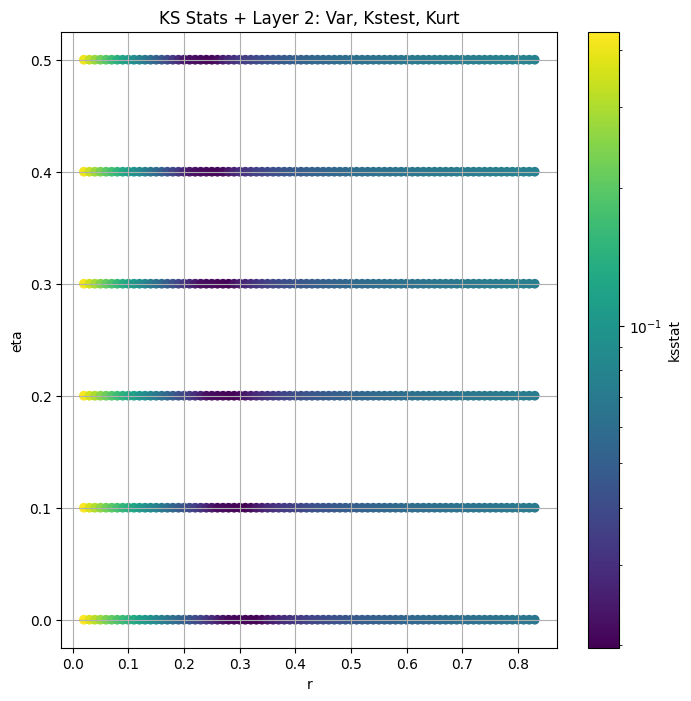

####
Layer  3


  9%|▊         | 1877/21967 [00:13<02:21, 141.94it/s]


KeyboardInterrupt: 

In [ ]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict = dict()

if True or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS[:2]):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for exclude_cutoff in EXCLUDE_CUTOFFS:
            exclude_cutoff = int(exclude_cutoff)
            if exclude_cutoff == 0:
                augmented_obs_var = np.var(group_data_map[group]) 
            else:
                augmented_obs_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                

            group_cdf_df['scale'] = np.clip((augmented_obs_var / group_cdf_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdf_df['scale'])
            augmented_obs_var_df[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdf_df[f'ksstat_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_obs_var)
            
            if min_stat < master_df.loc[group, 'kstest_stat_initial']:
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdf_df.loc[(group_cdf_df["r"] ==  initial_param[0]) & (group_cdf_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_obs_var
        
        ksstats = group_cdf_df[f"ksstat_{int(master_df.loc[group, 'best_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdf_df['variance']), 0,  SCALE_CAP)

        group_cdf_df['variance'] = group_cdf_df['variance'] * best_scales
        group_cdf_df['kurtosis'] = group_cdf_df['kurtosis'] * best_scales

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df

        temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
        rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']] + [temp_df[f'ksstat_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS]

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))
    augmented_obs_var_df.to_csv(augmented_obs_var_df_path)

augmented_obs_var_df = pd.read_csv(augmented_obs_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

In [29]:
augmented_obs_var_df

,obs_var,var_exclude_0,MAD,var_exclude_100,var_exclude_400,kstest_stat_0,kstest_stat_100,kstest_stat_400
layer,,,,,,,,
2,188570.730000,188570.734375,158.803253,36420.285156,16658.740234,0.024065,0.019771,0.053043
3,42568.312000,42568.312500,70.613350,12236.730469,7121.162598,0.024065,0.019771,0.053043
4,10773.336000,10773.335938,31.406000,3574.999512,2194.888672,0.024065,0.019771,0.053043
5,1800.434900,1800.434937,13.657659,642.706543,398.910187,0.024065,0.019771,0.053043
6,390.887500,390.887512,6.584007,129.362122,82.370354,0.024065,0.019771,0.053043
7,98.479220,98.479218,3.446948,29.994589,21.009548,0.024065,0.019771,0.053043
8,33.173733,33.173733,2.206926,11.896943,8.784658,0.024065,0.019771,0.053043
9,11.252635,11.252635,1.132474,3.280626,2.395398,0.024065,0.019771,0.053043
10,1.875914,1.875914,0.412296,0.463169,0.331123,0.024065,0.019771,0.053043


## Optimization

In [31]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

In [45]:
augmented_obs_var_df

,obs_var,var_exclude_0,MAD,var_exclude_100,var_exclude_400,kstest_stat_0,kstest_stat_100,kstest_stat_400,kstest_stat_50_iter1,var_50_iter1,kstest_stat_75_iter1,var_75_iter1,kstest_stat_100_iter1,var_100_iter1,kstest_stat_125_iter1,var_125_iter1,kstest_stat_150_iter1,var_150_iter1,var_0
layer,,,,,,,,,,,,,,,,,,,
2,188570.730000,188570.734375,158.803253,36420.285156,16658.740234,NaN,0.019771,0.053043,NaN,45081.785156,NaN,40213.917969,NaN,NaN,NaN,33320.988281,NaN,30676.792969,NaN
3,42568.312000,42568.312500,70.613350,12236.730469,7121.162598,0.024065,0.019771,0.053043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10773.336000,10773.335938,31.406000,3574.999512,2194.888672,0.024065,0.019771,0.053043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1800.434900,1800.434937,13.657659,642.706543,398.910187,0.024065,0.019771,0.053043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,390.887500,390.887512,6.584007,129.362122,82.370354,0.024065,0.019771,0.053043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,98.479220,98.479218,3.446948,29.994589,21.009548,0.024065,0.019771,0.053043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,33.173733,33.173733,2.206926,11.896943,8.784658,0.024065,0.019771,0.053043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,11.252635,11.252635,1.132474,3.280626,2.395398,0.024065,0.019771,0.053043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1.875914,1.875914,0.412296,0.463169,0.331123,0.024065,0.019771,0.053043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
group_cdfs_df#.loc[(group_cdfs_df["r"] ==  best_param[0]) & (group_cdfs_df["eta"] ==  best_param[1])]["scale"]#.iloc[0]

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis,scale,pass_var,pass_kurt,ksstat,pass_kstest
0,"((0.32, -0.1), <scipy.interpolate._fitpack2.In...",0.32,-0.10,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.527781e-93,7.755345e-95,6.737435e-96,False,False,0.508222,False
1,"((0.32, -0.09), <scipy.interpolate._fitpack2.I...",0.32,-0.09,<scipy.interpolate._fitpack2.InterpolatedUniva...,NaN,NaN,NaN,False,False,NaN,False
2,"((0.32, -0.08), <scipy.interpolate._fitpack2.I...",0.32,-0.08,<scipy.interpolate._fitpack2.InterpolatedUniva...,NaN,NaN,NaN,False,False,NaN,False
3,"((0.32, -0.07), <scipy.interpolate._fitpack2.I...",0.32,-0.07,<scipy.interpolate._fitpack2.InterpolatedUniva...,NaN,NaN,NaN,False,False,NaN,False
4,"((0.32, -0.06), <scipy.interpolate._fitpack2.I...",0.32,-0.06,<scipy.interpolate._fitpack2.InterpolatedUniva...,NaN,NaN,NaN,False,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
415,"((0.34, 0.05), <scipy.interpolate._fitpack2.In...",0.34,0.05,<scipy.interpolate._fitpack2.InterpolatedUniva...,NaN,NaN,NaN,False,False,NaN,False
416,"((0.34, 0.06), <scipy.interpolate._fitpack2.In...",0.34,0.06,<scipy.interpolate._fitpack2.InterpolatedUniva...,NaN,NaN,NaN,False,False,NaN,False
417,"((0.34, 0.07), <scipy.interpolate._fitpack2.In...",0.34,0.07,<scipy.interpolate._fitpack2.InterpolatedUniva...,NaN,NaN,NaN,False,False,NaN,False
418,"((0.34, 0.08), <scipy.interpolate._fitpack2.In...",0.34,0.08,<scipy.interpolate._fitpack2.InterpolatedUniva...,NaN,NaN,NaN,False,False,NaN,False


Layer 2


100%|██████████| 420/420 [00:01<00:00, 250.95it/s]


Finding Minimum after computing 420 CDFs


100%|██████████| 420/420 [00:01<00:00, 311.77it/s]


Finding Minimum after computing 420 CDFs
2 50 nan 45081.785


100%|██████████| 420/420 [00:01<00:00, 310.68it/s]


Finding Minimum after computing 420 CDFs
2 75 nan 40213.918


100%|██████████| 420/420 [00:01<00:00, 279.75it/s]


Finding Minimum after computing 420 CDFs
2 125 nan 33320.99


100%|██████████| 420/420 [00:01<00:00, 243.76it/s]


Finding Minimum after computing 420 CDFs
2 150 nan 30676.793
Iter 1 layer 2 best parameters: (0.32, -0.09, nan, nan)


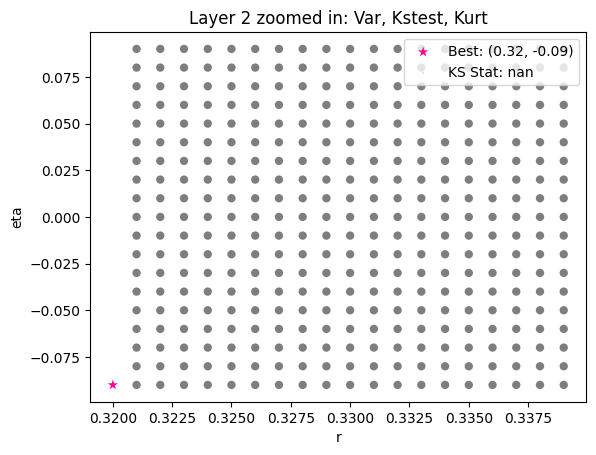

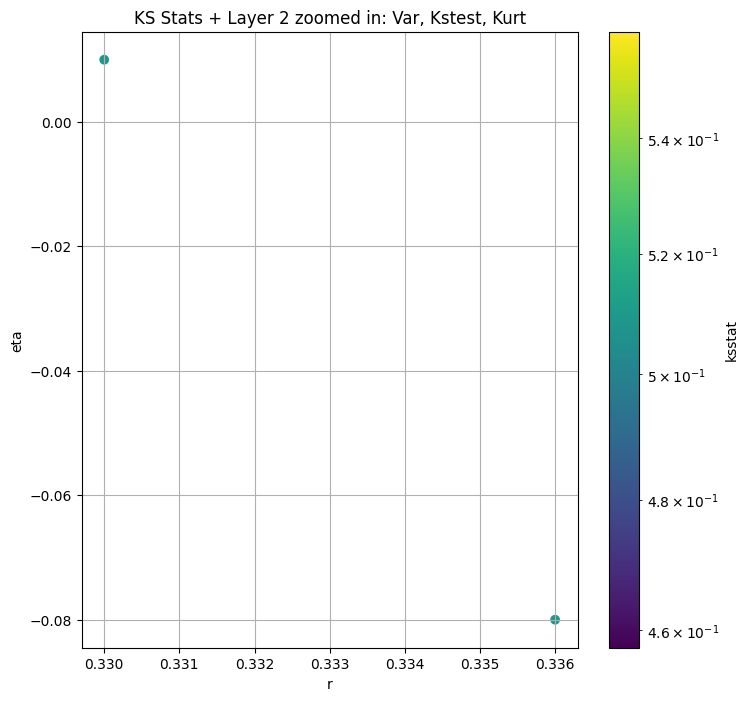

Layer 3


ValueError: cannot convert float NaN to integer

In [ ]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 100
EXCLUDE_CUTOFFS_OPTIMIZE = np.hstack([[0], np.arange(-50, 0, 25), np.arange(25, 51, 25)])

if True or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']

    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']

                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                group_cdfs = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                group_cdfs_df = create_kurt_var_ksstat_df(group_cdfs)

                
                for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE:
                    exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'best_exclude_cutoff']))
                    if exclude_cutoff == 0: # First time around
                        augmented_obs_var = np.var(group_data_map[group])

                    else:
                        augmented_obs_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])   

                    if adjust_exclude_cutoff == 0:

                        group_cdfs_df['scale'] = np.clip((augmented_obs_var / group_cdf_df['variance']), 0,  SCALE_CAP)
                        ksstats, best_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                        augmented_obs_var_df.loc[group, f"kstest_stat_adjust_{adjust_exclude_cutoff}"] = min_stat
                        augmented_obs_var_df.loc[group, f"var_adjust_{adjust_exclude_cutoff}"] = augmented_obs_var
                        master_df.loc[group, 'kstest_stat_best'] = min_stat
                        master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = best_param
                        master_df.loc[group, 'best_scale'] = group_cdfs_df.loc[(group_cdfs_df["r"] ==  best_param[0]) & (group_cdfs_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                        master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                        master_df.loc[group, 'best_augmented_var'] = augmented_obs_var
                        best_ksstats = ksstats

                    else:

                        group_cdfs_df['scale'] = np.clip((augmented_obs_var / group_cdf_df['variance']), 0,  SCALE_CAP)
                        ksstats, best_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                        augmented_obs_var_df.loc[group, f"kstest_stat_{exclude_cutoff}_iter{d}"] = min_stat
                        augmented_obs_var_df.loc[group, f"var_{exclude_cutoff}_iter{d}"] = augmented_obs_var
                        
                        print(group, exclude_cutoff, min_stat, augmented_obs_var)

                        if min_stat < master_df.loc[group, 'kstest_stat_best']:
                            master_df.loc[group, 'kstest_stat_best'] = min_stat
                            master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = best_param
                            master_df.loc[group, 'best_scale'] = group_cdfs_df.loc[(group_cdfs_df["r"] ==  best_param[0]) & (group_cdfs_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                            master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                            master_df.loc[group, 'best_augmented_var'] = augmented_obs_var
                            best_ksstats = ksstats
      
                best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdf_df['variance']), 0,  SCALE_CAP)
                group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
                group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

                group_cdfs_df = add_tests_to_df(cdfs_df=group_cdfs_df, group=group, var_kurt_df=master_df, ksstats=best_ksstats)

                print(f"Iter {d} {GROUP} {group} best parameters: {master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'], master_df.loc[group, 'best_scale'], master_df.loc[group, f'kstest_stat_best']}")

            filtered_df = group_cdfs_df[(group_cdfs_df['r'] > master_df.loc[group, 'initial_r'] - r_granularity) & 
                            (group_cdfs_df['r'] < master_df.loc[group, 'initial_r'] + r_granularity) &
                            (group_cdfs_df['eta'] > master_df.loc[group, 'initial_eta'] - eta_granularity) &
                            (group_cdfs_df['eta'] < master_df.loc[group, 'initial_eta'] + eta_granularity)]
            
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_obs_var_df.to_csv(augmented_obs_var_df_path)

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df

In [ ]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))